# Import

In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, SGDRegressor, ElasticNet, BayesianRidge, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import HistGradientBoostingRegressor

from bb_energy_prediction import models, evaluate, train, data_utils, sklearn_regressors

c:\Users\thodo\miniconda3\envs\energy-prediction\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

True

# Setup

In [3]:
no_dupl = False
if no_dupl:
    data_df = data_utils.get_data_df(data_path="../energy_data/no_dupl_data.pkl")
else:
    data_df = data_utils.get_data_df(data_path="../energy_data/data.pkl")
    
vocab = data_utils.get_inst_vocab(data_df)
data_df["encoded_bb"] = data_df.bb.apply(lambda x: data_utils.encode_bb_from_vocab(x, vocab, max_insts=20))
data_df.sample(3)

,bb,energy,program_name,bb_embeddings,encoded_bb
225544,"[mov %rdi %rax, mov %rdi %r9, sub $0x1 %r8, mu...",0.880866,ip,"[[2.5854805, -0.6781729, 0.8800227, 0.45015368...","[37, 118, 119, 53, 116, 17, 121, 117, 39, 120,..."
215171,"[mov %rsi %rbp, mov %rdx %r12, mov %rdx %rbx, ...",0.358872,ip,"[[2.5854802, -0.6781732, 0.8800236, 0.4501543,...","[478, 496, 46, 502]"
355968,"[movq $0x1, sub %rdi %rdx, jmp]",0.089124,variable_name,"[[0.8586008, 0.37870914, 2.0187523, -0.8874969...","[319, 69, 5]"


In [4]:
len(data_df)

561654

# Program Preds

In [5]:
program_data_size = data_df.program_name.value_counts()
program_data_size

variable_name       208472
find_biggest         54529
find_dyn_sum         49427
ip_get               41078
ip                   39246
time                 23687
function_pointer     19034
quicksort            17043
print_N              15514
polinominal          14909
random               13761
bubblesort           10560
declare              10304
simple_sort           7440
parrallel_ask2_b      6412
parrallel_ask2_a      6351
reverse_number        6230
zombie                5198
game_of_life          3562
bin_to_dec            3203
swap                  2573
faa                   1228
binary_search          982
count_file             911
Name: program_name, dtype: int64

In [6]:
test_programs_groups = [
    ["find_biggest", "binary_search", "count_file"],
    ["variable_name"],
    ["find_dyn_sum", "faa", "swap"],
    ["bin_to_dec", "ip_get", "game_of_life", "random"],
    ["ip", "zombie", "reverse_number", "parrallel_ask2_a", "parrallel_ask2_b"],
    ["simple_sort", "declare", "bubblesort", "time"],
    ["function_pointer", "quicksort", "print_N", "polinominal"]
]

test_sizes = [[program_data_size[prog] for prog in progs] for progs in test_programs_groups]
group_size = [sum(test_size) for test_size in test_sizes]
group_size

[56422, 208472, 53228, 61604, 63437, 51991, 66500]

In [7]:
program_names = np.unique(data_df.program_name)

results_dict = {}
for program in program_names:
    results_dict[program] = {}
    results_dict[program]["labels"] = data_df[data_df.program_name == program].energy.tolist()

In [8]:
results_dict_dir = "/Users/thodo/Documents/sxoli/diplomatiki/basic-block-energy-prediction/results/program_results.json"

if results_dict_dir.split("/")[-1] not in os.listdir(results_dict_dir.rsplit("/", 1)[0]):
    with open(results_dict_dir, 'w') as json_file:
        json.dump(results_dict, json_file, indent=4)

## Palmtree

### LSTM

Evaluating ['find_biggest', 'binary_search', 'count_file'] benchmarks.
Total test data: 56422


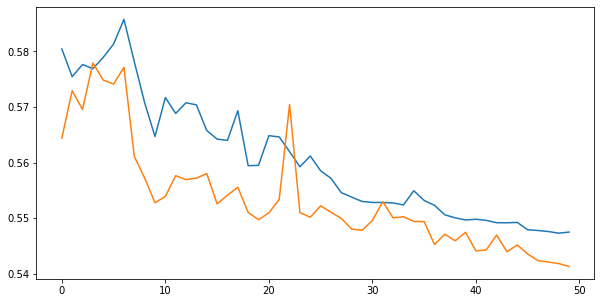

Evaluating ['variable_name'] benchmarks.
Total test data: 208472


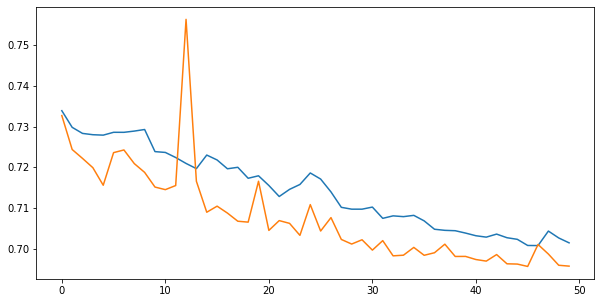

Evaluating ['find_dyn_sum', 'faa', 'swap'] benchmarks.
Total test data: 53228


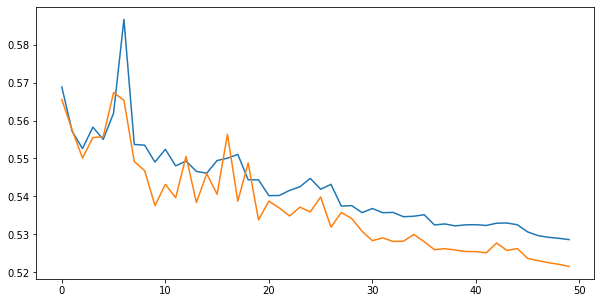

Evaluating ['bin_to_dec', 'ip_get', 'game_of_life', 'random'] benchmarks.
Total test data: 61604


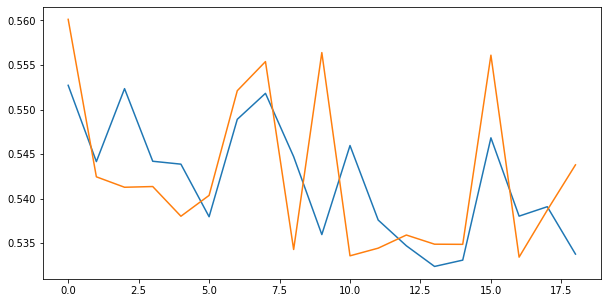

Evaluating ['ip', 'zombie', 'reverse_number', 'parrallel_ask2_a', 'parrallel_ask2_b'] benchmarks.
Total test data: 63437


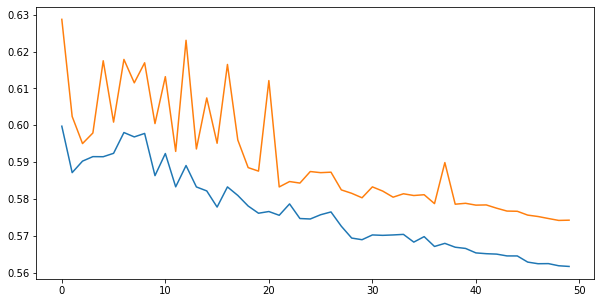

Evaluating ['simple_sort', 'declare', 'bubblesort', 'time'] benchmarks.
Total test data: 51991


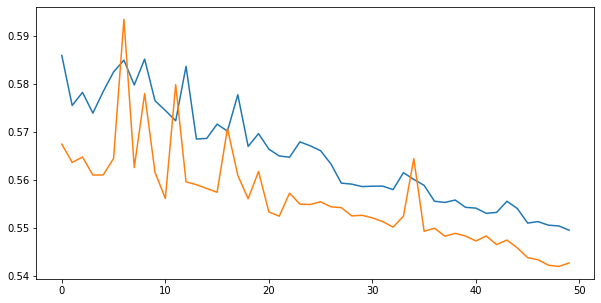

In [9]:
with open("/Users/thodo/Documents/sxoli/diplomatiki/basic-block-energy-prediction/model_checkpoints/lstm_palmtree_models/base_model/additional_attributes.json") as json_file:
    model_config = json.load(json_file)

model_params = model_config["model_params"]
train_params = model_config["train_params"]
model_name = "lstm_palmtree"

for test_programs in test_programs_groups[:-1]:
    
    with open(results_dict_dir) as json_file:
        results_dict = json.load(json_file)

    print(f"Evaluating {test_programs} benchmarks.")
    print(f"Total test data: {sum(program_data_size[prog] for prog in test_programs)}")

    test_data_df = data_df[data_df.program_name.isin(test_programs)]
    train_val_df = data_df[~data_df.program_name.isin(test_programs)]

    data_loaders = data_utils.get_data_dict(
        data_df=train_val_df,
        enc_type="palmtree",
        mean=False,
        batch_size=model_config["batch_size"],
        split=0.9,
    )

    train_loader = data_loaders["train_loader"]
    val_loader = data_loaders["val_loader"]

    embedding_size = next(iter(train_loader))[0].shape[-1]

    model = models.LSTM_Regressor(embedding_size=embedding_size, **model_params)
    
    train_results = train.train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        **train_params,
        verbose=False,
    )

    plt.figure(figsize=(10, 5))
    plt.plot(train_results["train_loss"])
    plt.plot(train_results["val_loss"])
    plt.show()

    for test_program in test_programs:
        prog_df = test_data_df[test_data_df.program_name == test_program]
        test_bbs = [emb.tolist() for emb in prog_df.bb_embeddings.tolist()]
        test_preds = evaluate.predict(model=model, test_bbs=test_bbs)
        results_dict[test_program][f"{model_name}_preds"] = test_preds.tolist()
        with open(results_dict_dir, 'w') as json_file:
            json.dump(results_dict, json_file, indent=4)

### Simple

In [43]:
with open("/Users/thodo/Documents/sxoli/diplomatiki/basic-block-energy-prediction/model_checkpoints/simple_palmtree_models/base_model/additional_attributes.json") as json_file:
    model_config = json.load(json_file)

model_params = model_config["model_params"]
train_params = model_config["train_params"]

model_name = "simple_palmtree"

for test_programs in test_programs_groups[:1]:
    
    with open(results_dict_dir) as json_file:
        results_dict = json.load(json_file)

    print(f"Evaluating {test_programs} benchmarks.")
    print(f"Total test data: {sum(program_data_size[prog] for prog in test_programs)}")

    test_data_df = data_df[data_df.program_name.isin(test_programs)]
    train_val_df = data_df[~data_df.program_name.isin(test_programs)]

    data_loaders = data_utils.get_data_dict(
        data_df=train_val_df,
        enc_type="palmtree",
        mean=True,
        batch_size=model_config["batch_size"],
        split=0.9,
    )

    train_loader = data_loaders["train_loader"]
    val_loader = data_loaders["val_loader"]

    embedding_size = next(iter(train_loader))[0].shape[-1]

    model = models.Simple_Regressor(embedding_size=embedding_size, **model_params)
    
    train_results = train.train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        **train_params,
        verbose=False,
    )

    for test_program in test_programs:
        prog_df = test_data_df[test_data_df.program_name == test_program]
        test_embs = [emb.tolist() for emb in prog_df.bb_embeddings.tolist()]
        test_preds = evaluate.predict(model=model, test_bbs=test_embs)
        results_dict[test_program][f"{model_name}_preds"] = test_preds.tolist()
        with open(results_dict_dir, 'w') as json_file:
            json.dump(results_dict, json_file, indent=4)

Evaluating ['find_biggest', 'binary_search', 'count_file'] benchmarks.
Total test data: 56422


## Vocab

Evaluating ['find_biggest', 'binary_search', 'count_file'] benchmarks.
Total test data: 56422


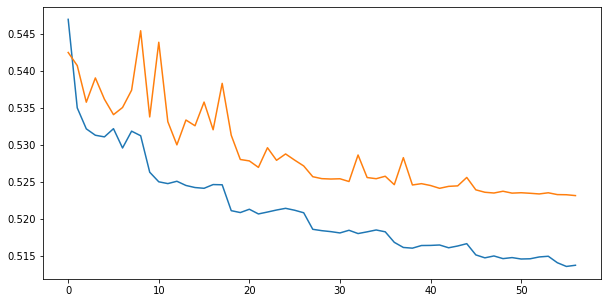

In [10]:
with open("/Users/thodo/Documents/sxoli/diplomatiki/basic-block-energy-prediction/model_checkpoints/lstm_vocab_models/base_model/additional_attributes.json") as json_file:
    model_config = json.load(json_file)

model_params = model_config["model_params"]
train_params = model_config["train_params"]

model_name = "lstm_vocab"

for test_programs in [test_programs_groups[0]]:
    
    with open(results_dict_dir) as json_file:
        results_dict = json.load(json_file)

    print(f"Evaluating {test_programs} benchmarks.")
    print(f"Total test data: {sum(program_data_size[prog] for prog in test_programs)}")

    test_data_df = data_df[data_df.program_name.isin(test_programs)]
    train_val_df = data_df[~data_df.program_name.isin(test_programs)]

    data_loaders = data_utils.get_data_dict(
        data_df=train_val_df,
        enc_type="vocab",
        batch_size=model_config["batch_size"],
        split=0.9,
    )

    train_loader = data_loaders["train_loader"]
    val_loader = data_loaders["val_loader"]

    embedding_size = next(iter(train_loader))[0].shape[-1]

    model = models.LSTM_Regressor(vocab_size=len(vocab), custom_embs=True, **model_params)
    
    train_results = train.train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        verbose=False,
        **train_params,
    )

    plt.figure(figsize=(10, 5))
    plt.plot(train_results["train_loss"])
    plt.plot(train_results["val_loss"])
    plt.show()

    for test_program in test_programs:
        prog_df = test_data_df[test_data_df.program_name == test_program]
        test_preds = evaluate.predict(model=model, test_bbs=prog_df.bb.tolist(), vocab=vocab)
        results_dict[test_program][f"{model_name}_preds"] = test_preds.tolist()
        with open(results_dict_dir, 'w') as json_file:
            json.dump(results_dict, json_file, indent=4)

## Regressors

In [10]:
regressors = [
    "linear",
    "lasso",
    "ridge",
    "elasticnet",
    "sgd",
    "hist_gradient_boosting",
    "svr",
]

In [11]:
for regressor_name in [regressors[-1]]:
    print(f"Regressor: {regressor_name}\n")
    with open(f"/Users/thodo/Documents/sxoli/diplomatiki/basic-block-energy-prediction/model_checkpoints/regressors/{regressor_name}/additional_attributes.json") as json_file:
        model_config = json.load(json_file)

    pipe_params = model_config["pipe_params"]
    if regressor_name != "linear":
        regressor_params = model_config["regressor_params"]

    for test_programs in test_programs_groups:
        
        with open(results_dict_dir) as json_file:
            results_dict = json.load(json_file)

        print(f"Evaluating {test_programs} benchmarks.")
        print(f"Total test data: {sum(program_data_size[prog] for prog in test_programs)}")

        train_val_df = data_df[~data_df.program_name.isin(test_programs)]
        test_data_df = data_df[data_df.program_name.isin(test_programs)]

        X_train = np.array([" ".join(bb) for bb in train_val_df.bb.tolist()])
        y_train = train_val_df.energy.values

        X_test = np.array([" ".join(bb) for bb in test_data_df.bb.tolist()])
        y_test = test_data_df.energy.values
        
        if regressor_name == "linear":
            regressor = LinearRegression()
        elif regressor_name == "lasso":
            regressor = Lasso(**regressor_params)
        elif regressor_name == "ridge":
            regressor = Ridge(**regressor_params)
        elif regressor_name == "elasticnet":
            regressor = ElasticNet(**regressor_params)
        elif regressor_name == "sgd":
            regressor = SGDRegressor(**regressor_params)
        elif regressor_name == "svr":
            X_train = X_train[:50000]
            y_train = y_train[:50000]
            regressor = SVR(**regressor_params)
        elif regressor_name == "hist_gradient_boosting":
            regressor = HistGradientBoostingRegressor(**regressor_params)

        pipe = sklearn_regressors.train_pipe(regressor, X_train, y_train, **pipe_params)

        for test_program in test_programs:
            prog_df = test_data_df[test_data_df.program_name == test_program]
            prog_bbs = np.array([" ".join(bb) for bb in prog_df.bb.tolist()])
            test_preds = pipe.predict(prog_bbs)
            results_dict[test_program][f"{regressor_name}_preds"] = test_preds.tolist()
            with open(results_dict_dir, 'w') as json_file:
                json.dump(results_dict, json_file, indent=4)

Regressor: svr

Evaluating ['find_biggest', 'binary_search', 'count_file'] benchmarks.
Total test data: 56422
Evaluating ['variable_name'] benchmarks.
Total test data: 208472
Evaluating ['find_dyn_sum', 'faa', 'swap'] benchmarks.
Total test data: 53228
Evaluating ['bin_to_dec', 'ip_get', 'game_of_life', 'random'] benchmarks.
Total test data: 61604
Evaluating ['ip', 'zombie', 'reverse_number', 'parrallel_ask2_a', 'parrallel_ask2_b'] benchmarks.
Total test data: 63437
Evaluating ['simple_sort', 'declare', 'bubblesort', 'time'] benchmarks.
Total test data: 51991
Evaluating ['function_pointer', 'quicksort', 'print_N', 'polinominal'] benchmarks.
Total test data: 66500


# General Test Preds

In [12]:
results_dict_dir = "/Users/thodo/Documents/sxoli/diplomatiki/basic-block-energy-prediction/results/test_runs_results.json"
random_states = [7, 17, 42, 69, 420]

initialize = False
if results_dict_dir.split("/")[-1] not in os.listdir(results_dict_dir.rsplit("/", 1)[0]):
    initialize = True
    results_dict = {}
else:
    with open(results_dict_dir) as json_file:
        results_dict = json.load(json_file)

for test_run, random_state in enumerate(random_states):
    if initialize:
        results_dict[f"test_run_{test_run}"] = {}
    shuffled_data_df = data_df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    test_size = int(0.1 * len(shuffled_data_df))
    test_data_df = shuffled_data_df[-test_size:]
    results_dict[f"test_run_{test_run}"][f"labels"] = test_data_df.energy.tolist()

if initialize:
    with open(results_dict_dir, 'w') as json_file:
        json.dump(results_dict, json_file, indent=4)

## Palmtree

### LSTM

Test Run: 0


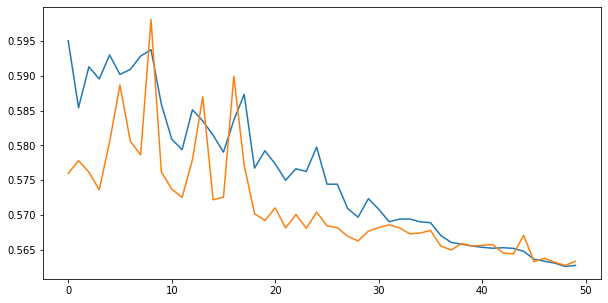

Test Run: 1


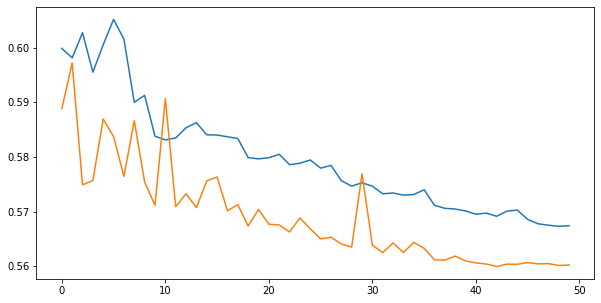

Test Run: 2


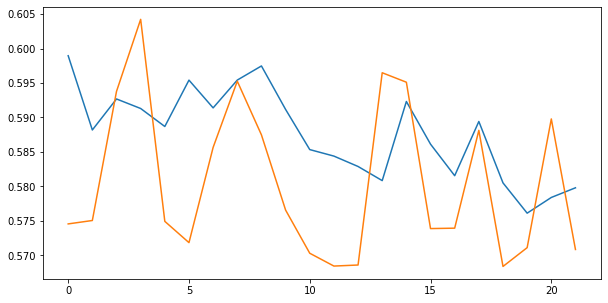

Test Run: 3


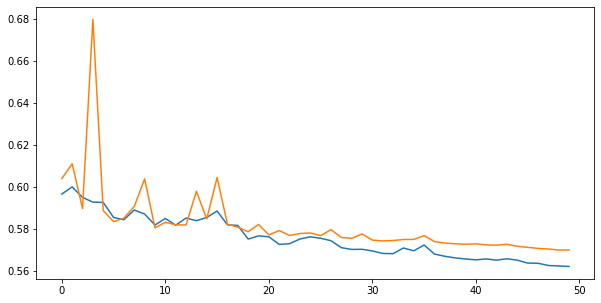

Test Run: 4


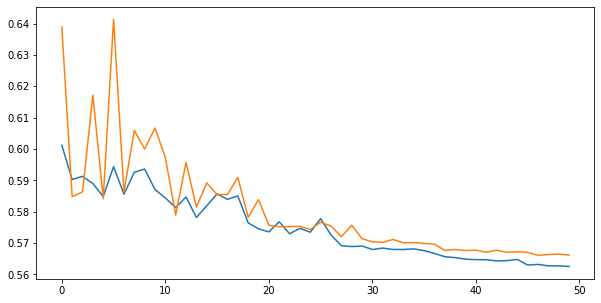

In [12]:
with open("/Users/thodo/Documents/sxoli/diplomatiki/basic-block-energy-prediction/model_checkpoints/lstm_palmtree_models/base_model/additional_attributes.json") as json_file:
    model_config = json.load(json_file)

model_params = model_config["model_params"]
train_params = model_config["train_params"]
model_name = "lstm_palmtree"

for test_run, random_state in enumerate(random_states):
    
    print(f"Test Run: {test_run}")

    with open(results_dict_dir) as json_file:
        results_dict = json.load(json_file)

    shuffled_data_df = data_df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    test_size = int(0.1 * len(shuffled_data_df))
    test_data_df = shuffled_data_df[-test_size:]
    train_val_df = shuffled_data_df[:-test_size]

    data_loaders = data_utils.get_data_dict(
        data_df=train_val_df,
        enc_type="palmtree",
        mean=False,
        batch_size=model_config["batch_size"],
        split=0.9,
        random_state=random_state,
    )

    train_loader = data_loaders["train_loader"]
    val_loader = data_loaders["val_loader"]

    embedding_size = next(iter(train_loader))[0].shape[-1]

    model = models.LSTM_Regressor(embedding_size=embedding_size, **model_params)
    
    train_results = train.train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        **train_params,
        verbose=False,
    )

    plt.figure(figsize=(10, 5))
    plt.plot(train_results["train_loss"])
    plt.plot(train_results["val_loss"])
    plt.show()

    test_bbs = [emb.tolist() for emb in test_data_df.bb_embeddings.tolist()]
    test_preds = evaluate.predict(model=model, test_bbs=test_bbs)
    results_dict[f"test_run_{test_run}"][f"{model_name}_preds"] = test_preds.tolist()
    with open(results_dict_dir, 'w') as json_file:
        json.dump(results_dict, json_file, indent=4)

### Simple

In [7]:
with open("/Users/thodo/Documents/sxoli/diplomatiki/basic-block-energy-prediction/model_checkpoints/simple_palmtree_models/base_model/additional_attributes.json") as json_file:
    model_config = json.load(json_file)

model_params = model_config["model_params"]
train_params = model_config["train_params"]

model_name = "simple_palmtree"

for test_run, random_state in enumerate(random_states):
    
    print(f"Test Run: {test_run}")

    with open(results_dict_dir) as json_file:
        results_dict = json.load(json_file)

    shuffled_data_df = data_df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    test_size = int(0.1 * len(shuffled_data_df))
    test_data_df = shuffled_data_df[-test_size:]
    train_val_df = shuffled_data_df[:-test_size]

    data_loaders = data_utils.get_data_dict(
        data_df=train_val_df,
        enc_type="palmtree",
        mean=True,
        batch_size=model_config["batch_size"],
        split=0.9,
        random_state=random_state,
    )

    train_loader = data_loaders["train_loader"]
    val_loader = data_loaders["val_loader"]

    embedding_size = next(iter(train_loader))[0].shape[-1]

    model = models.Simple_Regressor(embedding_size=embedding_size, **model_params)
    
    train_results = train.train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        **train_params,
        verbose=False,
    )

    test_bbs = [emb.tolist() for emb in test_data_df.bb_embeddings.tolist()]
    test_preds = evaluate.predict(model=model, test_bbs=test_bbs)
    results_dict[f"test_run_{test_run}"][f"{model_name}_preds"] = test_preds.tolist()
    with open(results_dict_dir, 'w') as json_file:
        json.dump(results_dict, json_file, indent=4)

Test Run: 0
Test Run: 1
Test Run: 2
Test Run: 3
Test Run: 4


## Vocab

Test Run: 0


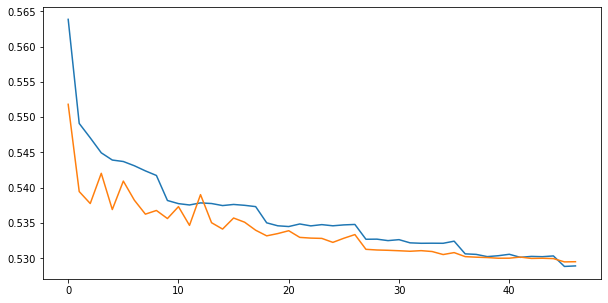

Test Run: 1


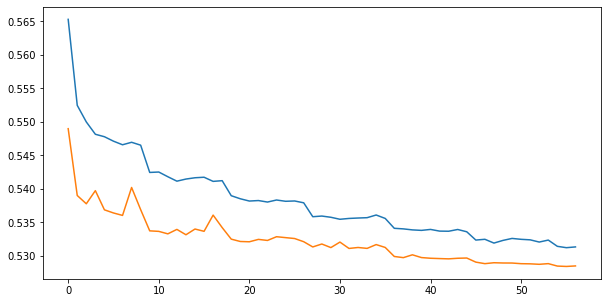

Test Run: 2


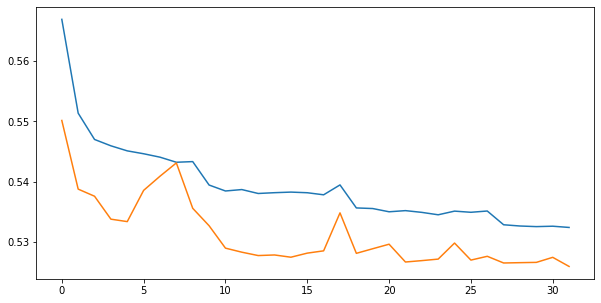

Test Run: 3


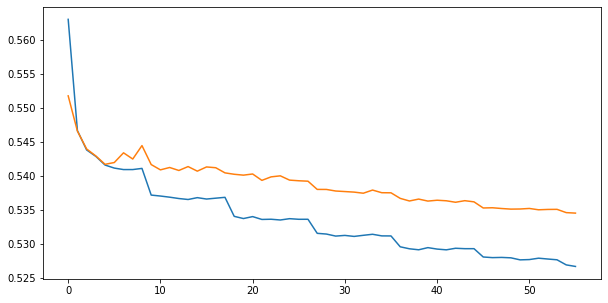

Test Run: 4


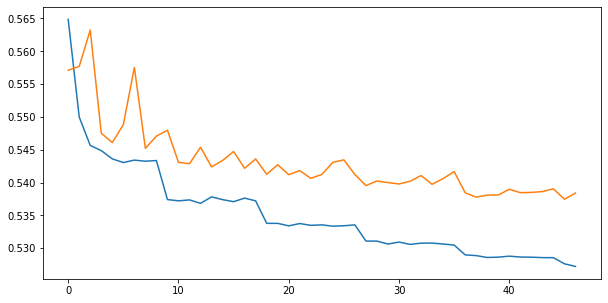

In [6]:
with open("/Users/thodo/Documents/sxoli/diplomatiki/basic-block-energy-prediction/model_checkpoints/lstm_vocab_models/base_model/additional_attributes.json") as json_file:
    model_config = json.load(json_file)

model_params = model_config["model_params"]
train_params = model_config["train_params"]
model_name = "lstm_vocab"

for test_run, random_state in enumerate(random_states):
    
    print(f"Test Run: {test_run}")

    with open(results_dict_dir) as json_file:
        results_dict = json.load(json_file)

    shuffled_data_df = data_df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    test_size = int(0.1 * len(shuffled_data_df))
    test_data_df = shuffled_data_df[-test_size:]
    train_val_df = shuffled_data_df[:-test_size]

    data_loaders = data_utils.get_data_dict(
        data_df=train_val_df,
        enc_type="vocab",
        batch_size=model_config["batch_size"],
        split=0.9,
        random_state=random_state,
    )

    train_loader = data_loaders["train_loader"]
    val_loader = data_loaders["val_loader"]

    embedding_size = next(iter(train_loader))[0].shape[-1]

    model = models.LSTM_Regressor(vocab_size=len(vocab), custom_embs=True, **model_params)
    
    train_results = train.train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        verbose=False,
        **train_params,
    )

    plt.figure(figsize=(10, 5))
    plt.plot(train_results["train_loss"])
    plt.plot(train_results["val_loss"])
    plt.show()

    test_preds = evaluate.predict(model=model, test_bbs=test_data_df.bb.tolist(), vocab=vocab)
    results_dict[f"test_run_{test_run}"][f"{model_name}_preds"] = test_preds.tolist()
    with open(results_dict_dir, 'w') as json_file:
        json.dump(results_dict, json_file, indent=4)

## Regressors

In [13]:
regressors = [
    "linear",
    "lasso",
    "ridge",
    "elasticnet",
    "sgd",
    "hist_gradient_boosting",
    "svr",
]

In [14]:
for regressor_name in [regressors[-1]]:
    print(f"Regressor: {regressor_name}\n")
    with open(f"/Users/thodo/Documents/sxoli/diplomatiki/basic-block-energy-prediction/model_checkpoints/regressors/{regressor_name}/additional_attributes.json") as json_file:
        model_config = json.load(json_file)

    pipe_params = model_config["pipe_params"]
    if regressor_name != "linear":
        regressor_params = model_config["regressor_params"]

    for test_run, random_state in enumerate(random_states):
        
        print(f"Test Run: {test_run}")

        with open(results_dict_dir) as json_file:
            results_dict = json.load(json_file)

        shuffled_data_df = data_df.sample(frac=1, random_state=random_state).reset_index(drop=True)
        test_size = int(0.1 * len(shuffled_data_df))
        test_data_df = shuffled_data_df[-test_size:]
        train_val_df = shuffled_data_df[:-test_size]

        X_train = np.array([" ".join(bb) for bb in train_val_df.bb.tolist()])
        y_train = train_val_df.energy.values

        X_test = np.array([" ".join(bb) for bb in test_data_df.bb.tolist()])
        y_test = test_data_df.energy.values
        
        if regressor_name == "linear":
            regressor = LinearRegression()
        elif regressor_name == "lasso":
            regressor = Lasso(**regressor_params)
        elif regressor_name == "ridge":
            regressor = Ridge(**regressor_params)
        elif regressor_name == "elasticnet":
            regressor = ElasticNet(**regressor_params)
        elif regressor_name == "sgd":
            regressor = SGDRegressor(**regressor_params)
        elif regressor_name == "svr":
            X_train = X_train[:50000]
            y_train = y_train[:50000]
            regressor = SVR(**regressor_params)
        elif regressor_name == "hist_gradient_boosting":
            regressor = HistGradientBoostingRegressor(**regressor_params)

        pipe = sklearn_regressors.train_pipe(regressor, X_train, y_train, **pipe_params)

        
        test_bbs = np.array([" ".join(bb) for bb in test_data_df.bb.tolist()])
        test_preds = pipe.predict(test_bbs)
        results_dict[f"test_run_{test_run}"][f"{regressor_name}_preds"] = test_preds.tolist()
        with open(results_dict_dir, 'w') as json_file:
            json.dump(results_dict, json_file, indent=4)

Regressor: svr

Test Run: 0
Test Run: 1
Test Run: 2
Test Run: 3
Test Run: 4


# General Test Preds No Duplicates

In [5]:
results_dict_dir = "/Users/thodo/Documents/sxoli/diplomatiki/basic-block-energy-prediction/results/test_runs_no_dupl_results.json"
random_states = [7, 17, 42, 69, 420]

initialize = False
if results_dict_dir.split("/")[-1] not in os.listdir(results_dict_dir.rsplit("/", 1)[0]):
    initialize = True
    results_dict = {}
else:
    with open(results_dict_dir) as json_file:
        results_dict = json.load(json_file)

for test_run, random_state in enumerate(random_states):
    if initialize:
        results_dict[f"test_run_{test_run}"] = {}
    shuffled_data_df = data_df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    test_size = int(0.15 * len(shuffled_data_df))
    test_data_df = shuffled_data_df[-test_size:]
    results_dict[f"test_run_{test_run}"][f"labels"] = test_data_df.energy.tolist()

if initialize:
    with open(results_dict_dir, 'w') as json_file:
        json.dump(results_dict, json_file, indent=4)

## Palmtree

### LSTM

Test Run: 0


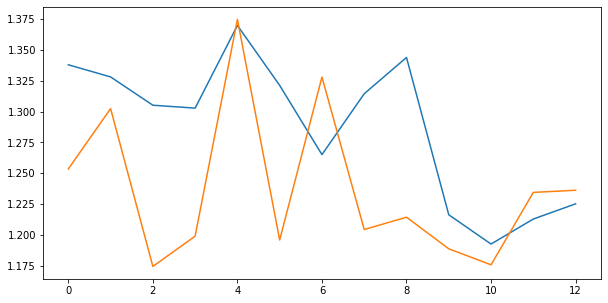

Test Run: 1


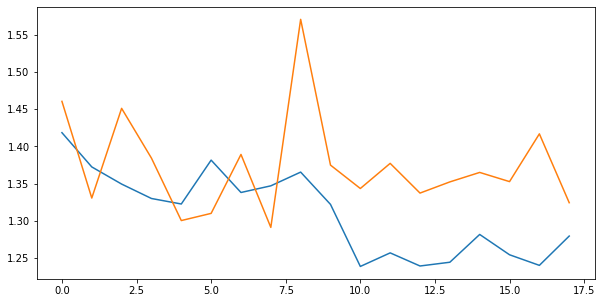

Test Run: 2


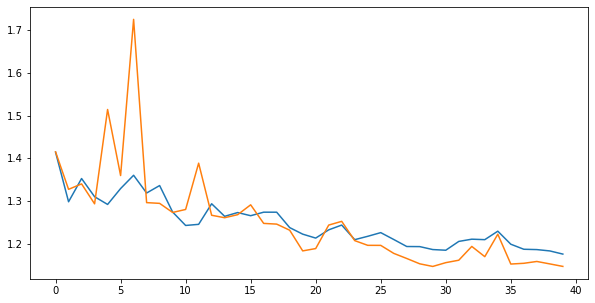

Test Run: 3


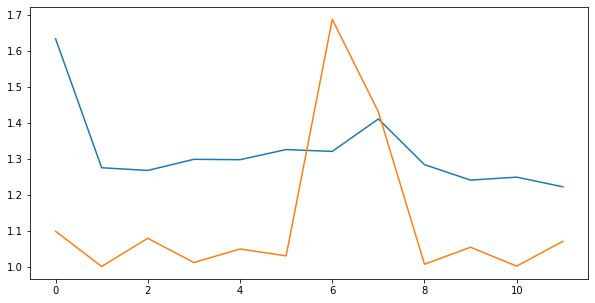

Test Run: 4


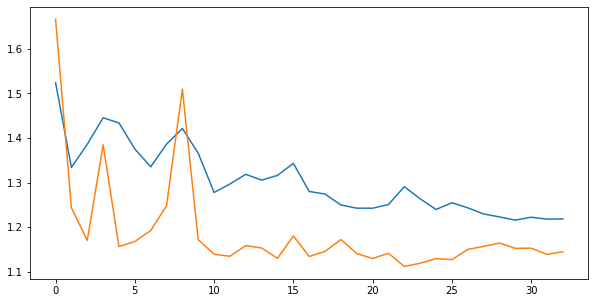

In [9]:
with open("/Users/thodo/Documents/sxoli/diplomatiki/basic-block-energy-prediction/model_checkpoints/lstm_palmtree_models/model_no_dupl/additional_attributes.json") as json_file:
    model_config = json.load(json_file)

model_params = model_config["model_params"]
train_params = model_config["train_params"]
model_name = "lstm_palmtree"

for test_run, random_state in enumerate(random_states):
    
    print(f"Test Run: {test_run}")

    with open(results_dict_dir) as json_file:
        results_dict = json.load(json_file)

    shuffled_data_df = data_df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    test_size = int(0.15 * len(shuffled_data_df))
    test_data_df = shuffled_data_df[-test_size:]
    train_val_df = shuffled_data_df[:-test_size]

    data_loaders = data_utils.get_data_dict(
        data_df=train_val_df,
        enc_type="palmtree",
        mean=False,
        batch_size=model_config["batch_size"],
        split=0.85,
        random_state=random_state,
    )

    train_loader = data_loaders["train_loader"]
    val_loader = data_loaders["val_loader"]

    embedding_size = next(iter(train_loader))[0].shape[-1]

    model = models.LSTM_Regressor(embedding_size=embedding_size, **model_params)
    
    train_results = train.train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        verbose=False,
        **train_params,
    )

    plt.figure(figsize=(10, 5))
    plt.plot(train_results["train_loss"])
    plt.plot(train_results["val_loss"])
    plt.show()

    test_bbs = [emb.tolist() for emb in test_data_df.bb_embeddings.tolist()]
    test_preds = evaluate.predict(model=model, test_bbs=test_bbs)
    results_dict[f"test_run_{test_run}"][f"{model_name}_preds"] = test_preds.tolist()
    with open(results_dict_dir, 'w') as json_file:
        json.dump(results_dict, json_file, indent=4)

### Simple

In [10]:
with open("/Users/thodo/Documents/sxoli/diplomatiki/basic-block-energy-prediction/model_checkpoints/simple_palmtree_models/model_no_dupl/additional_attributes.json") as json_file:
    model_config = json.load(json_file)

model_params = model_config["model_params"]
train_params = model_config["train_params"]

model_name = "simple_palmtree"

for test_run, random_state in enumerate(random_states):
    
    print(f"Test Run: {test_run}")

    with open(results_dict_dir) as json_file:
        results_dict = json.load(json_file)

    shuffled_data_df = data_df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    test_size = int(0.15 * len(shuffled_data_df))
    test_data_df = shuffled_data_df[-test_size:]
    train_val_df = shuffled_data_df[:-test_size]

    data_loaders = data_utils.get_data_dict(
        data_df=train_val_df,
        enc_type="palmtree",
        mean=True,
        batch_size=model_config["batch_size"],
        split=0.85,
        random_state=random_state,
    )

    train_loader = data_loaders["train_loader"]
    val_loader = data_loaders["val_loader"]

    embedding_size = next(iter(train_loader))[0].shape[-1]

    model = models.Simple_Regressor(embedding_size=embedding_size, **model_params)
    
    train_results = train.train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        **train_params,
        verbose=False,
    )

    test_bbs = [emb.tolist() for emb in test_data_df.bb_embeddings.tolist()]
    test_preds = evaluate.predict(model=model, test_bbs=test_bbs)
    results_dict[f"test_run_{test_run}"][f"{model_name}_preds"] = test_preds.tolist()
    with open(results_dict_dir, 'w') as json_file:
        json.dump(results_dict, json_file, indent=4)

Test Run: 0
Test Run: 1
Test Run: 2
Test Run: 3
Test Run: 4


## Vocab

Test Run: 0


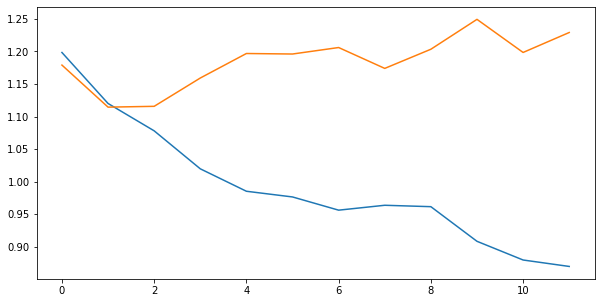

Test Run: 1


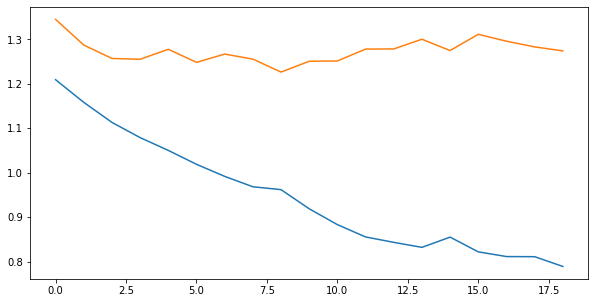

Test Run: 2


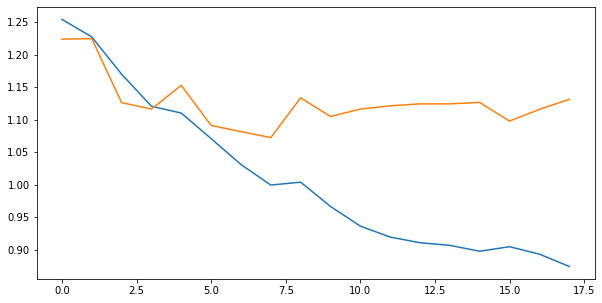

Test Run: 3


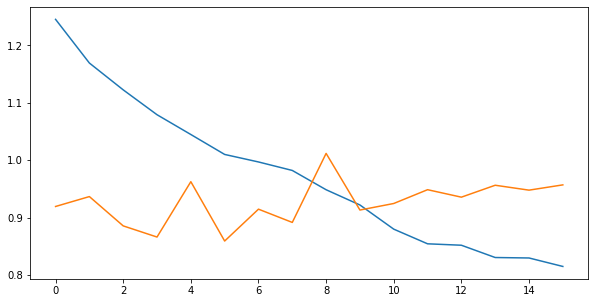

Test Run: 4


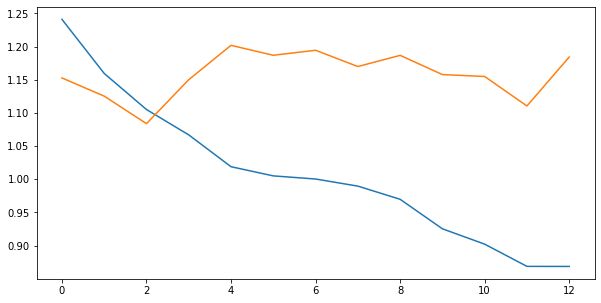

In [6]:
with open("/Users/thodo/Documents/sxoli/diplomatiki/basic-block-energy-prediction/model_checkpoints/lstm_vocab_models/model_no_dupl/additional_attributes.json") as json_file:
    model_config = json.load(json_file)

model_params = model_config["model_params"]
train_params = model_config["train_params"]
model_name = "lstm_vocab"

for test_run, random_state in enumerate(random_states):
    
    print(f"Test Run: {test_run}")

    with open(results_dict_dir) as json_file:
        results_dict = json.load(json_file)

    shuffled_data_df = data_df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    test_size = int(0.15 * len(shuffled_data_df))
    test_data_df = shuffled_data_df[-test_size:]
    train_val_df = shuffled_data_df[:-test_size]

    data_loaders = data_utils.get_data_dict(
        data_df=train_val_df,
        enc_type="vocab",
        batch_size=model_config["batch_size"],
        split=0.85,
        random_state=random_state,
    )

    train_loader = data_loaders["train_loader"]
    val_loader = data_loaders["val_loader"]

    embedding_size = next(iter(train_loader))[0].shape[-1]

    model = models.LSTM_Regressor(vocab_size=len(vocab), custom_embs=True, **model_params)
    
    train_results = train.train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        **train_params,
        verbose=False,
    )

    plt.figure(figsize=(10, 5))
    plt.plot(train_results["train_loss"])
    plt.plot(train_results["val_loss"])
    plt.show()

    test_preds = evaluate.predict(model=model, test_bbs=test_data_df.bb.tolist(), vocab=vocab)
    results_dict[f"test_run_{test_run}"][f"{model_name}_preds"] = test_preds.tolist()
    with open(results_dict_dir, 'w') as json_file:
        json.dump(results_dict, json_file, indent=4)

## Regressors

In [6]:
regressors = [
    #"linear",
    #"lasso",
    #"ridge",
    #"elasticnet",
    #"sgd",
    "hist_gradient_boosting",
    "svr",
]

In [7]:
for regressor_name in regressors:
    print(f"Regressor: {regressor_name}\n")
    with open(f"/Users/thodo/Documents/sxoli/diplomatiki/basic-block-energy-prediction/model_checkpoints/regressors_no_dupl/{regressor_name}/additional_attributes.json") as json_file:
        model_config = json.load(json_file)

    pipe_params = model_config["pipe_params"]
    if regressor_name != "linear":
        regressor_params = model_config["regressor_params"]

    for test_run, random_state in enumerate(random_states):
        
        print(f"Test Run: {test_run}")

        with open(results_dict_dir) as json_file:
            results_dict = json.load(json_file)

        shuffled_data_df = data_df.sample(frac=1, random_state=random_state).reset_index(drop=True)
        test_size = int(0.15 * len(shuffled_data_df))
        test_data_df = shuffled_data_df[-test_size:]
        train_val_df = shuffled_data_df[:-test_size]

        X_train = np.array([" ".join(bb) for bb in train_val_df.bb.tolist()])
        y_train = train_val_df.energy.values

        X_test = np.array([" ".join(bb) for bb in test_data_df.bb.tolist()])
        y_test = test_data_df.energy.values
        
        if regressor_name == "linear":
            regressor = LinearRegression()
        elif regressor_name == "lasso":
            regressor = Lasso(**regressor_params)
        elif regressor_name == "ridge":
            regressor = Ridge(**regressor_params)
        elif regressor_name == "elasticnet":
            regressor = ElasticNet(**regressor_params)
        elif regressor_name == "sgd":
            regressor = SGDRegressor(**regressor_params)
        elif regressor_name == "svr":
            regressor = SVR(**regressor_params)
        elif regressor_name == "hist_gradient_boosting":
            regressor = HistGradientBoostingRegressor(**regressor_params)

        pipe = sklearn_regressors.train_pipe(regressor, X_train, y_train, **pipe_params)

        
        test_bbs = np.array([" ".join(bb) for bb in test_data_df.bb.tolist()])
        test_preds = pipe.predict(test_bbs)
        results_dict[f"test_run_{test_run}"][f"{regressor_name}_preds"] = test_preds.tolist()
        with open(results_dict_dir, 'w') as json_file:
            json.dump(results_dict, json_file, indent=4)

Regressor: hist_gradient_boosting

Test Run: 0
Test Run: 1
Test Run: 2
Test Run: 3
Test Run: 4
Regressor: svr

Test Run: 0
Test Run: 1
Test Run: 2
Test Run: 3
Test Run: 4
